In [1]:
import sys
import numpy as np
import pysindy as ps
import inspect
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import copy

from pysindy.feature_library import GeneralizedLibrary, PolynomialLibrary, FourierLibrary, CustomLibrary, ConcatLibrary


In [2]:
def competitionModel(t, q, params):
        u, v = q
        # r, a1, a2, b1,b2
        r, a1, a2, b1,b2 = params
        dudt = u*(1-a1*u- a2*v)  
        dvdt = r*v*(1-b1*u-b2*v)
        return [dudt, dvdt]
def plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test):
    dt = t_test[1] - t_test[0]
    mse = np.zeros(len(threshold_scan))
    mse_sim = np.zeros(len(threshold_scan))
    for i in range(len(threshold_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0,:], t_test, integrator="odeint")
        if np.any(x_test_sim > 1e4):
            x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test - x_test_sim) ** 2)
    
    #plt.figure(figsize=(5, 2), dpi=300)
    plt.figure()
    plt.semilogy(threshold_scan, mse, "bo")
    plt.semilogy(threshold_scan, mse, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=16)
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    
    # plt.figure(figsize=(5, 2), dpi=300)
    # plt.figure()
    plt.semilogy(threshold_scan, mse_sim, "bo")
    plt.semilogy(threshold_scan, mse_sim, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=16)
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)

# Model Comparison
def plot_models(t_end, initial_condition, params, original_model, sindy_model):
    t_span = (0, t_end)
    t_eval = np.linspace(t_span[0], t_span[1], 500)
    sol = solve_ivp(original_model, t_span, initial_condition, args=(params,), t_eval=t_eval)
    t = sol.t
    u_sol = sol.y[0].T 
    v_sol = sol.y[1].T

    # syndy model output
    out = sindy_model.simulate(initial_condition, t_eval, integrator='odeint')
    u_predicted = out[:, 0]
    v_predicted = out[:, 1]

    # plot
    plt.figure(figsize=(5, 3))
    plt.plot(t, u_sol, label='Original u', color='blue')
    plt.plot(t, u_predicted, label='SINDy u', linestyle='--', color='yellow')
    plt.plot(t, v_sol, label='Original v', color='red')
    plt.plot(t, v_predicted, label='SINDy v', linestyle='--', color='black')
    plt.xlabel('Time (t)')
    plt.ylabel('u')
    plt.title('Comparison of Original and SINDy Models')
    plt.legend()
    plt.show()

In [3]:
# Ic and constants
initial_conditions = [2,1]
# survival of one species
# params = [r, a1, a2, b1, b2]
#params = [0.5, 0.3, 0.6, 0.7, 0.3] 
# co-existence
params = [0.5, 0.7, 0.3, 0.3, 0.6]

# time span. i.e. 24 months.
t_end = 24
t_span = (0, t_end)
t_eval = np.linspace(t_span[0], t_span[1], 500) # 100 time steps

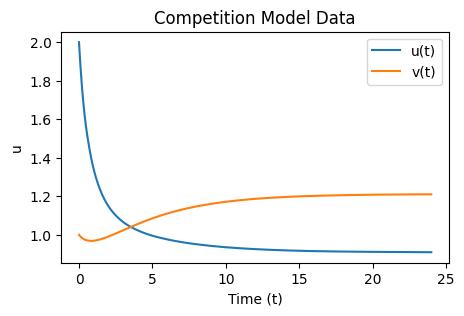

In [4]:
# Training dataset
sol = solve_ivp(competitionModel, t_span, initial_conditions, args=(params,), t_eval=t_eval)
t_train = sol.t
x_train = sol.y.T
u_train = sol.y[0]
v_train = sol.y[1]

# Test datasets
sol_test = solve_ivp(competitionModel, t_span, initial_conditions, args=(params,), t_eval=t_eval)
t_test = sol_test.t
x_test = sol_test.y.T
u_test = sol_test.y[0]
v_test = sol_test.y[1]


plt.figure(figsize=(5, 3))
plt.plot(t_train, u_train, label='u(t)')
plt.plot(t_train, v_train, label='v(t)')
plt.xlabel('Time (t)')
plt.ylabel('u')
plt.title('Competition Model Data')
plt.legend()
plt.show()


c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


def competitionModel(t, q, params):
        u, v = q
        # r, a1, a2, b1,b2
        r, a1, a2, b1,b2 = params
        dudt = u*(1-a1*u- a2*v)  
        dvdt = r*v*(1-b1*u-b2*v)
        return [dudt, dvdt]

(u)' = -2.544 1 + 2.517 u + 3.730 v + -0.622 u^2 + -2.072 u v + -1.000 v^2
(v)' = 0.500 v + -0.150 u v + -0.300 v^2


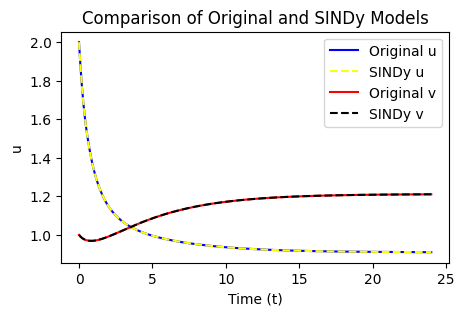

In [5]:
# try PySINDy

model = ps.SINDy(feature_names=["u", "v"], optimizer=ps.SR3(threshold=0.05))
model.fit(x_train, t=t_train)

print(inspect.getsource(competitionModel))
model.print()
plot_models(t_end, initial_conditions, params, competitionModel, model)

Add noise

(u)' = 0.351 1 + -0.403 u^2
(v)' = -1.505 1 + 2.868 v + -1.342 v^2


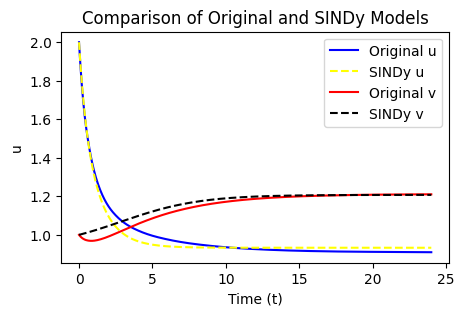

In [6]:
np.random.seed(0)
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 100.0,  x_train.shape)
feature_names = ["u", "v"]

poly_order = 2
poly_library = PolynomialLibrary(degree=poly_order)
fourier_library = FourierLibrary()
combined_library = GeneralizedLibrary([poly_library, fourier_library])

sparse_regression_optimizer = ps.SR3(threshold=0.3, thresholder="l1")
modelX = ps.SINDy(feature_names=feature_names,
                     optimizer=sparse_regression_optimizer, 
                     feature_library=poly_library,)

modelX.fit(x_train_added_noise, t=t_train, quiet=True)
modelX.print()
plot_models(t_end, initial_conditions, params, competitionModel, modelX)

In [7]:
out = modelX.simulate(initial_conditions, t_eval, integrator='odeint')

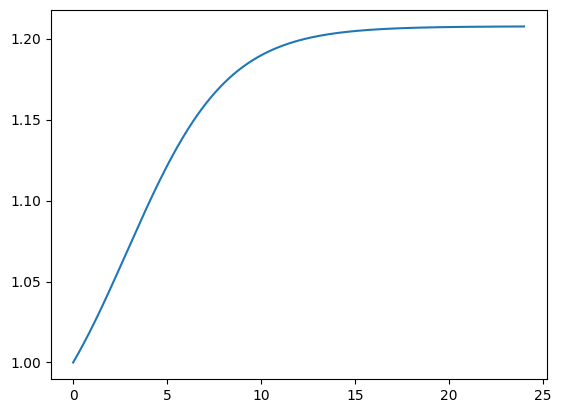

In [8]:
out[:, 1] = np.where(out[:, 1] > 2 , 0, out[:, 1])
plt.plot(t_train, out[:, 1])

0.01
(u)' = -2.544 1 + 2.517 u + 3.730 v + -0.622 u^2 + -2.072 u v + -1.000 v^2
(v)' = -0.109 1 + 0.575 v + -0.050 u^2 + -0.372 v^2
0.01473684210526316
(u)' = -2.544 1 + 2.517 u + 3.730 v + -0.622 u^2 + -2.072 u v + -1.000 v^2
(v)' = -0.109 1 + 0.575 v + -0.050 u^2 + -0.372 v^2
0.019473684210526317
(u)' = -2.544 1 + 2.517 u + 3.730 v + -0.622 u^2 + -2.072 u v + -1.000 v^2
(v)' = -0.109 1 + 0.575 v + -0.050 u^2 + -0.372 v^2
0.024210526315789474
(u)' = -2.544 1 + 2.517 u + 3.730 v + -0.622 u^2 + -2.072 u v + -1.000 v^2
(v)' = 0.213 1 + -0.052 u^2 + -0.115 v^2


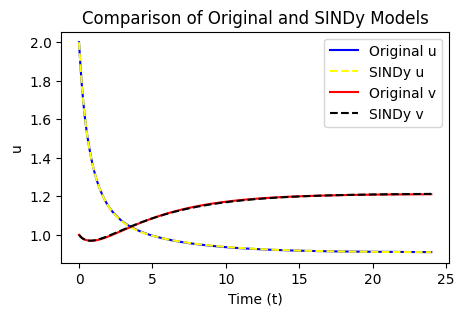

0.02894736842105263
(u)' = -2.544 1 + 2.517 u + 3.730 v + -0.622 u^2 + -2.072 u v + -1.000 v^2
(v)' = 0.213 1 + -0.052 u^2 + -0.115 v^2
0.03368421052631579
(u)' = -2.544 1 + 2.517 u + 3.730 v + -0.622 u^2 + -2.072 u v + -1.000 v^2
(v)' = 0.213 1 + -0.052 u^2 + -0.115 v^2
0.03842105263157895
(u)' = -2.544 1 + 2.517 u + 3.730 v + -0.622 u^2 + -2.072 u v + -1.000 v^2
(v)' = 0.213 1 + -0.052 u^2 + -0.115 v^2
0.04315789473684211
(u)' = -2.544 1 + 2.517 u + 3.730 v + -0.622 u^2 + -2.072 u v + -1.000 v^2
(v)' = 0.213 1 + -0.052 u^2 + -0.115 v^2
0.04789473684210527
(u)' = -2.544 1 + 2.517 u + 3.730 v + -0.622 u^2 + -2.072 u v + -1.000 v^2
(v)' = 0.213 1 + -0.052 u^2 + -0.115 v^2
0.052631578947368425
(u)' = -2.544 1 + 2.517 u + 3.730 v + -0.622 u^2 + -2.072 u v + -1.000 v^2
(v)' = 0.047 1 + -0.029 v^2
0.05736842105263158
(u)' = -2.544 1 + 2.517 u + 3.730 v + -0.622 u^2 + -2.072 u v + -1.000 v^2
(v)' = 0.047 1 + -0.029 v^2
0.06210526315789474
(u)' = -2.544 1 + 2.517 u + 3.730 v + -0.622 u^2 + -2

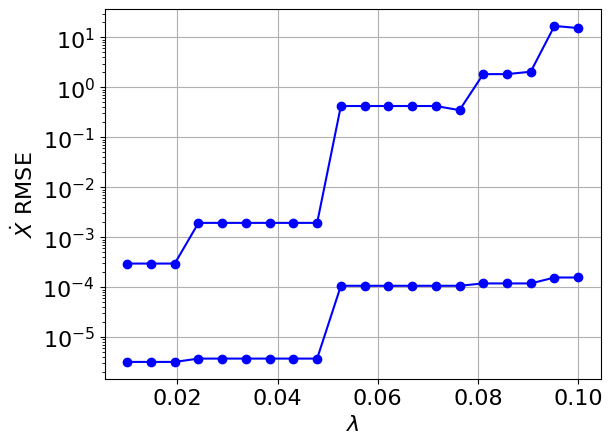

In [9]:
threshold_scan = np.linspace(0.01, 0.1, 20)
coefs = []
np.random.seed(0)

x_train_added_noise = x_train + np.random.normal(0, rmse / 100.0,  x_train.shape)
feature_names = ["u", "v"]

poly_order = 2
poly_library = PolynomialLibrary(degree=poly_order)
fourier_library = FourierLibrary()
combined_library = GeneralizedLibrary([poly_library, fourier_library])

for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.SR3(threshold=threshold, thresholder="l1")
    modelX = ps.SINDy(feature_names=feature_names,
                     optimizer=sparse_regression_optimizer, 
                     feature_library=poly_library,)
    # modelX.fit(x_train_added_noise, t=t_train, quiet=True)
    modelX.fit(x_train, t=t_train, quiet=True)
    coefs.append(modelX.coefficients())
    print(threshold)
    modelX.print()
    if i == 3:
        plot_models(t_end, initial_conditions, params, competitionModel, modelX)

plot_pareto(coefs, sparse_regression_optimizer, modelX,
            threshold_scan, x_test, t_test)

## Add time window
[0 15], poly_library, fourier_library, combined_library

0.0
(u)' = -1.586 1 + 1.394 u + 1.594 v + -1.212 u^2 + 0.754 u v + -0.988 v^2
(v)' = 12.456 1 + -6.510 u + -16.214 v + 0.648 u^2 + 4.629 u v + 5.096 v^2
0.034482758620689655
(u)' = -3.117 1 + 2.139 u + 3.830 v + -1.210 u^2 + -1.689 v^2
(v)' = 12.456 1 + -6.510 u + -16.214 v + 0.648 u^2 + 4.629 u v + 5.096 v^2
0.06896551724137931
(u)' = -0.592 1 + 1.647 u + -1.050 u^2 + -0.027 v^2
(v)' = 12.456 1 + -6.510 u + -16.214 v + 0.648 u^2 + 4.629 u v + 5.096 v^2
0.10344827586206896
(u)' = -0.592 1 + 1.647 u + -1.050 u^2 + -0.027 v^2
(v)' = 12.456 1 + -6.510 u + -16.214 v + 0.648 u^2 + 4.629 u v + 5.096 v^2
0.13793103448275862
(u)' = -0.716 1 + 1.783 u + -1.096 u^2
(v)' = 12.456 1 + -6.510 u + -16.214 v + 0.648 u^2 + 4.629 u v + 5.096 v^2


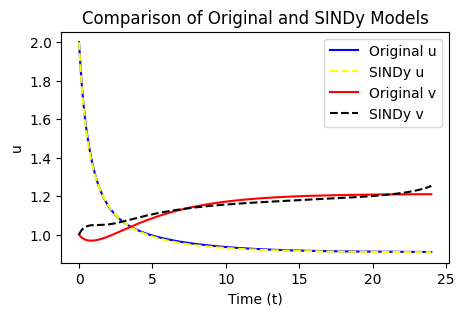

0.1724137931034483
(u)' = -0.716 1 + 1.783 u + -1.096 u^2
(v)' = 12.456 1 + -6.510 u + -16.214 v + 0.648 u^2 + 4.629 u v + 5.096 v^2
0.20689655172413793
(u)' = 0.375 1 + -0.415 u^2
(v)' = 7.203 1 + -4.668 u + -9.542 v + 4.710 u v + 2.324 v^2
0.24137931034482757
(u)' = 0.375 1 + -0.415 u^2
(v)' = -2.460 1 + 0.024 u + 4.556 v + -2.105 v^2
0.27586206896551724
(u)' = 0.375 1 + -0.415 u^2
(v)' = -2.061 1 + 3.908 v + -1.828 v^2
0.3103448275862069
(u)' = -0.127 u^2
(v)' = -2.061 1 + 3.908 v + -1.828 v^2
0.3448275862068966
(u)' = -0.127 u^2
(v)' = -2.061 1 + 3.908 v + -1.828 v^2
0.3793103448275862
(u)' = -0.127 u^2
(v)' = -2.061 1 + 3.908 v + -1.828 v^2
0.41379310344827586
(u)' = -0.127 u^2
(v)' = 0.096 1 + -0.073 v
0.4482758620689655
(u)' = -0.127 u^2
(v)' = 0.000
0.48275862068965514
(u)' = -0.127 u^2
(v)' = 0.000
0.5172413793103449
(u)' = 0.000
(v)' = 0.000
0.5517241379310345
(u)' = 0.000
(v)' = 0.000
0.5862068965517241
(u)' = 0.000
(v)' = 0.000
0.6206896551724138
(u)' = 0.000
(v)' = 0.000
0

c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


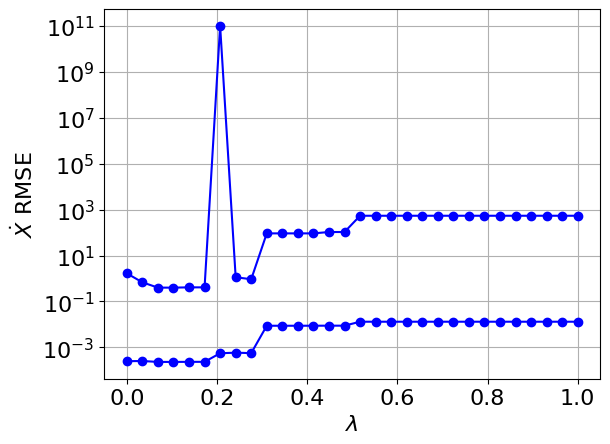

In [10]:
threshold_scan = np.linspace(0, 1, 30)
coefs = []
time_window = [0, 15]
mask = (t_train == 0) | ((t_train >= time_window[0]) & (t_train <= time_window[1]))
np.random.seed(0)

t_filtered = t_train[mask]
x_filtered = x_train[mask]

x_train_added_noise = x_filtered + np.random.normal(0, rmse / 100.0,  x_filtered.shape)
feature_names = ["u", "v"]

poly_order = 2
poly_library = PolynomialLibrary(degree=poly_order)
fourier_library = FourierLibrary()
combined_library = GeneralizedLibrary([poly_library, fourier_library])

for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.SR3(threshold=threshold, thresholder="l1")
    modelX = ps.SINDy(feature_names=feature_names,
                     optimizer=sparse_regression_optimizer, 
                     feature_library=poly_library,)
    modelX.fit(x_train_added_noise, t=t_filtered, quiet=True)
    coefs.append(modelX.coefficients())
    print(threshold)
    modelX.print()
    if i == 4:
        plot_models(t_end, initial_conditions, params, competitionModel, modelX)

plot_pareto(coefs, sparse_regression_optimizer, modelX,
            threshold_scan, x_test, t_test)

0.0
(u)' = 1.705 sin(1 u) + 1.671 cos(1 u) + -2.159 sin(1 v) + -0.983 cos(1 v)
(v)' = -1.058 sin(1 u) + -0.127 cos(1 u) + 0.604 sin(1 v) + 0.971 cos(1 v)
0.034482758620689655
(u)' = 1.705 sin(1 u) + 1.671 cos(1 u) + -2.159 sin(1 v) + -0.983 cos(1 v)
(v)' = -0.588 sin(1 u) + 0.244 sin(1 v) + 0.659 cos(1 v)


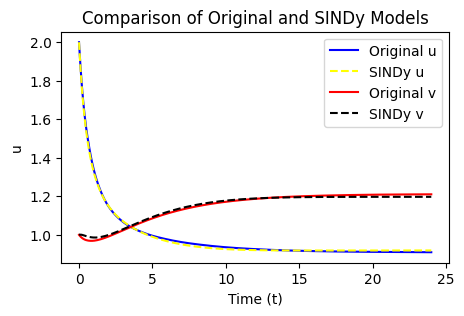

0.06896551724137931
(u)' = 0.618 sin(1 u) + 1.554 cos(1 u) + -1.556 sin(1 v)
(v)' = 0.000
0.10344827586206896
(u)' = 0.618 sin(1 u) + 1.554 cos(1 u) + -1.556 sin(1 v)
(v)' = 0.000
0.13793103448275862
(u)' = 1.281 cos(1 u) + -0.820 sin(1 v)
(v)' = 0.000
0.1724137931034483
(u)' = 1.281 cos(1 u) + -0.820 sin(1 v)
(v)' = 0.000
0.20689655172413793
(u)' = 1.281 cos(1 u) + -0.820 sin(1 v)
(v)' = 0.000
0.24137931034482757
(u)' = 1.281 cos(1 u) + -0.820 sin(1 v)
(v)' = 0.000
0.27586206896551724
(u)' = 1.281 cos(1 u) + -0.820 sin(1 v)
(v)' = 0.000
0.3103448275862069
(u)' = 1.281 cos(1 u) + -0.820 sin(1 v)
(v)' = 0.000
0.3448275862068966
(u)' = 1.281 cos(1 u) + -0.820 sin(1 v)
(v)' = 0.000
0.3793103448275862
(u)' = 1.281 cos(1 u) + -0.820 sin(1 v)
(v)' = 0.000
0.41379310344827586
(u)' = 1.281 cos(1 u) + -0.820 sin(1 v)
(v)' = 0.000
0.4482758620689655
(u)' = 1.281 cos(1 u) + -0.820 sin(1 v)
(v)' = 0.000
0.48275862068965514
(u)' = 1.281 cos(1 u) + -0.820 sin(1 v)
(v)' = 0.000
0.5172413793103449
(u)

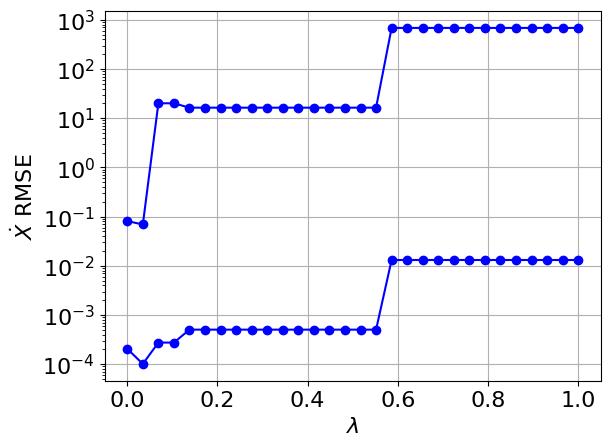

In [11]:
threshold_scan = np.linspace(0, 1, 30)
coefs = []
time_window = [0, 15]
mask = (t_train == 0) | ((t_train >= time_window[0]) & (t_train <= time_window[1]))
np.random.seed(0)

t_filtered = t_train[mask]
x_filtered = x_train[mask]

x_train_added_noise = x_filtered + np.random.normal(0, rmse / 100.0,  x_filtered.shape)
feature_names = ["u", "v"]

poly_order = 2
poly_library = PolynomialLibrary(degree=poly_order)
fourier_library = FourierLibrary()
combined_library = GeneralizedLibrary([poly_library, fourier_library])

for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.SR3(threshold=threshold, thresholder="l1")
    modelX = ps.SINDy(feature_names=feature_names,
                     optimizer=sparse_regression_optimizer, 
                     feature_library=fourier_library,)
    modelX.fit(x_train_added_noise, t=t_filtered, quiet=True)
    coefs.append(modelX.coefficients())
    print(threshold)
    modelX.print()
    if i == 1:
        plot_models(t_end, initial_conditions, params, competitionModel, modelX)

plot_pareto(coefs, sparse_regression_optimizer, modelX,
            threshold_scan, x_test, t_test)

0.0
(u)' = 1919.589 1 + 9.390 u + 4475.919 v + -10.881 u^2 + 7.832 u v + -2121.606 v^2 + -18.426 sin(1 u) + -15.655 cos(1 u) + -3712.419 sin(1 v) + -2095.729 cos(1 v)
(v)' = -689.102 1 + -146.785 u + -1031.700 v + 62.686 u^2 + -7.273 u v + 551.012 v^2 + 123.575 sin(1 u) + 43.737 cos(1 u) + 921.234 sin(1 v) + 663.047 cos(1 v)
0.034482758620689655
(u)' = 1919.589 1 + 9.390 u + 4475.919 v + -10.881 u^2 + 7.832 u v + -2121.606 v^2 + -18.426 sin(1 u) + -15.655 cos(1 u) + -3712.419 sin(1 v) + -2095.729 cos(1 v)
(v)' = -689.102 1 + -146.785 u + -1031.700 v + 62.686 u^2 + -7.273 u v + 551.012 v^2 + 123.575 sin(1 u) + 43.737 cos(1 u) + 921.234 sin(1 v) + 663.047 cos(1 v)
0.06896551724137931
(u)' = 1919.589 1 + 9.390 u + 4475.919 v + -10.881 u^2 + 7.832 u v + -2121.606 v^2 + -18.426 sin(1 u) + -15.655 cos(1 u) + -3712.419 sin(1 v) + -2095.729 cos(1 v)
(v)' = -689.102 1 + -146.785 u + -1031.700 v + 62.686 u^2 + -7.273 u v + 551.012 v^2 + 123.575 sin(1 u) + 43.737 cos(1 u) + 921.234 sin(1 v) + 663

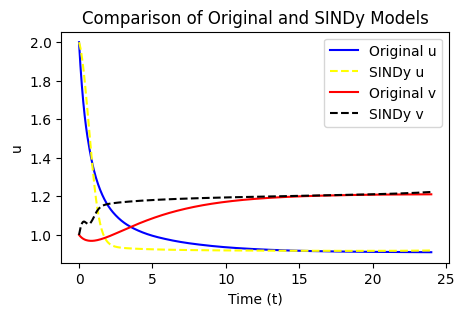

0.7586206896551724
(u)' = -8672.812 1 + -22043.790 v + 10241.130 v^2 + 18075.290 sin(1 v) + 9745.217 cos(1 v)
(v)' = -1423.136 1 + -193.956 u + -3581.663 v + 73.626 u^2 + 1659.789 v^2 + 146.599 sin(1 u) + 38.077 cos(1 u) + 2937.062 sin(1 v) + 1573.029 cos(1 v)
0.7931034482758621
(u)' = -8672.812 1 + -22043.790 v + 10241.130 v^2 + 18075.290 sin(1 v) + 9745.217 cos(1 v)
(v)' = -1423.136 1 + -193.956 u + -3581.663 v + 73.626 u^2 + 1659.789 v^2 + 146.599 sin(1 u) + 38.077 cos(1 u) + 2937.062 sin(1 v) + 1573.029 cos(1 v)
0.8275862068965517
(u)' = -8672.812 1 + -22043.790 v + 10241.130 v^2 + 18075.290 sin(1 v) + 9745.217 cos(1 v)
(v)' = -1423.136 1 + -193.956 u + -3581.663 v + 73.626 u^2 + 1659.789 v^2 + 146.599 sin(1 u) + 38.077 cos(1 u) + 2937.062 sin(1 v) + 1573.029 cos(1 v)
0.8620689655172413
(u)' = -8672.812 1 + -22043.790 v + 10241.130 v^2 + 18075.290 sin(1 v) + 9745.217 cos(1 v)
(v)' = -1423.136 1 + -193.956 u + -3581.663 v + 73.626 u^2 + 1659.789 v^2 + 146.599 sin(1 u) + 38.077 cos(1

c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quanti

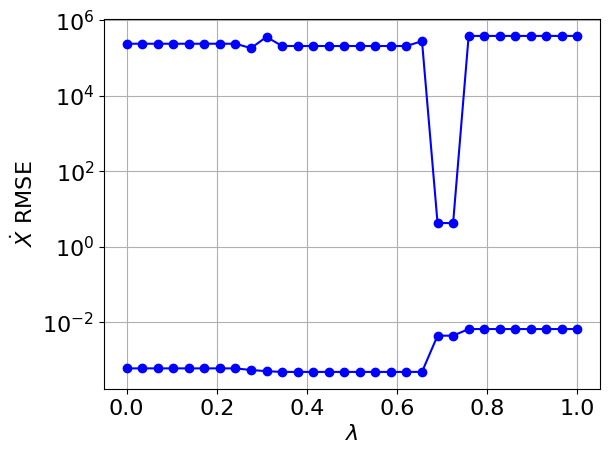

In [12]:
threshold_scan = np.linspace(0, 1, 30)
coefs = []
time_window = [0, 15]
mask = (t_train == 0) | ((t_train >= time_window[0]) & (t_train <= time_window[1]))
np.random.seed(0)

t_filtered = t_train[mask]
x_filtered = x_train[mask]

x_train_added_noise = x_filtered + np.random.normal(0, rmse / 100.0,  x_filtered.shape)
feature_names = ["u", "v"]

poly_order = 2
poly_library = PolynomialLibrary(degree=poly_order)
fourier_library = FourierLibrary()
combined_library = GeneralizedLibrary([poly_library, fourier_library])

for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.SR3(threshold=threshold, thresholder="l1")
    modelX = ps.SINDy(feature_names=feature_names,
                     optimizer=sparse_regression_optimizer, 
                     feature_library=combined_library,)
    modelX.fit(x_train_added_noise, t=t_filtered, quiet=True)
    coefs.append(modelX.coefficients())
    print(threshold)
    modelX.print()
    if i == 21:
        plot_models(t_end, initial_conditions, params, competitionModel, modelX)

plot_pareto(coefs, sparse_regression_optimizer, modelX,
            threshold_scan, x_test, t_test)

## time window = [10, 30]

0.0
(u)' = 74.680 1 + -71.538 u + -69.583 v + 7.840 u^2 + 47.551 u v + 10.764 v^2
(v)' = 35.987 1 + -24.513 u + -41.097 v + 3.130 u^2 + 15.536 u v + 11.164 v^2
0.020202020202020204
(u)' = 74.680 1 + -71.538 u + -69.583 v + 7.840 u^2 + 47.551 u v + 10.764 v^2
(v)' = 35.987 1 + -24.513 u + -41.097 v + 3.130 u^2 + 15.536 u v + 11.164 v^2
0.04040404040404041
(u)' = 74.680 1 + -71.538 u + -69.583 v + 7.840 u^2 + 47.551 u v + 10.764 v^2
(v)' = 35.987 1 + -24.513 u + -41.097 v + 3.130 u^2 + 15.536 u v + 11.164 v^2
0.06060606060606061
(u)' = 74.680 1 + -71.538 u + -69.583 v + 7.840 u^2 + 47.551 u v + 10.764 v^2
(v)' = 35.987 1 + -24.513 u + -41.097 v + 3.130 u^2 + 15.536 u v + 11.164 v^2
0.08080808080808081
(u)' = 74.680 1 + -71.538 u + -69.583 v + 7.840 u^2 + 47.551 u v + 10.764 v^2
(v)' = 35.987 1 + -24.513 u + -41.097 v + 3.130 u^2 + 15.536 u v + 11.164 v^2
0.10101010101010102
(u)' = 74.680 1 + -71.538 u + -69.583 v + 7.840 u^2 + 47.551 u v + 10.764 v^2
(v)' = 35.987 1 + -24.513 u + -41.097

c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


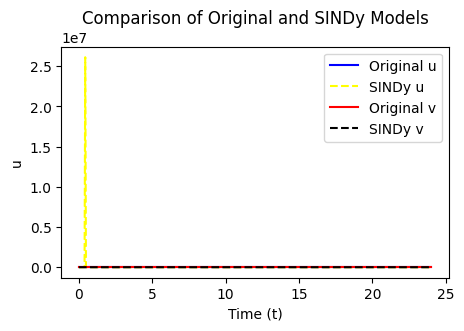

1.0303030303030305
(u)' = 48.109 1 + -58.251 u + -35.460 v + 6.538 u^2 + 38.496 u v
(v)' = 1.812 1 + -1.510 v
1.0505050505050506
(u)' = 48.109 1 + -58.251 u + -35.460 v + 6.538 u^2 + 38.496 u v
(v)' = 1.812 1 + -1.510 v
1.0707070707070707
(u)' = 48.109 1 + -58.251 u + -35.460 v + 6.538 u^2 + 38.496 u v
(v)' = 1.812 1 + -1.510 v
1.090909090909091
(u)' = 48.109 1 + -58.251 u + -35.460 v + 6.538 u^2 + 38.496 u v
(v)' = 1.812 1 + -1.510 v
1.1111111111111112
(u)' = 48.109 1 + -58.251 u + -35.460 v + 6.538 u^2 + 38.496 u v
(v)' = 1.812 1 + -1.510 v
1.1313131313131315
(u)' = 48.109 1 + -58.251 u + -35.460 v + 6.538 u^2 + 38.496 u v
(v)' = 1.812 1 + -1.510 v
1.1515151515151516
(u)' = 48.109 1 + -58.251 u + -35.460 v + 6.538 u^2 + 38.496 u v
(v)' = 0.001 1
1.1717171717171717
(u)' = 48.109 1 + -58.251 u + -35.460 v + 6.538 u^2 + 38.496 u v
(v)' = 0.000
1.191919191919192
(u)' = 48.109 1 + -58.251 u + -35.460 v + 6.538 u^2 + 38.496 u v
(v)' = 0.000
1.2121212121212122
(u)' = 48.109 1 + -58.251 u + 

c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quanti

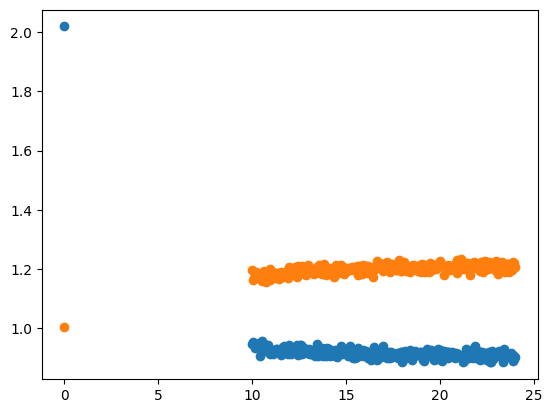

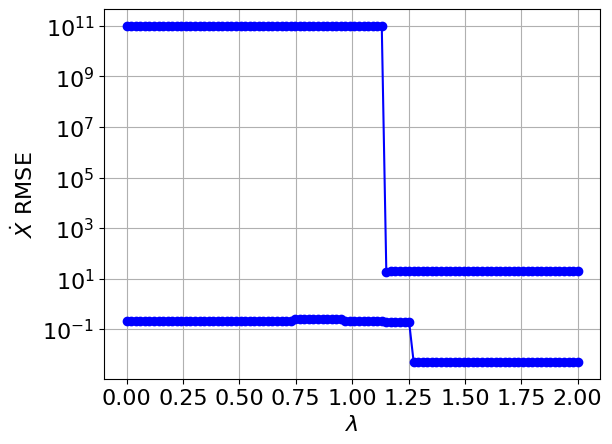

In [13]:
threshold_scan = np.linspace(0, 2, 100)
time_window = [10, 30]
mask = (t_train == 0) | ((t_train >= time_window[0]) & (t_train <= time_window[1]))
np.random.seed(0)
coefs= []

t_filtered = t_train[mask]
x_filtered = x_train[mask]

x_train_added_noise = x_filtered + np.random.normal(0, rmse / 100.0,  x_filtered.shape)
feature_names = ["u", "v"]

poly_order = 2
poly_library = PolynomialLibrary(degree=poly_order)
fourier_library = FourierLibrary()
combined_library = GeneralizedLibrary([poly_library, fourier_library])

for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.SR3(threshold=threshold, thresholder="l1")
    modelX = ps.SINDy(feature_names=feature_names,
                     optimizer=sparse_regression_optimizer, 
                     feature_library=poly_library,)
    modelX.fit(x_train_added_noise, t=t_filtered, quiet=True)
    coefs.append(modelX.coefficients())
    print(threshold)
    modelX.print()
    if i == 50:
        plot_models(t_end, initial_conditions, params, competitionModel, modelX)

plt.scatter(t_filtered, x_train_added_noise[:,0])
plt.scatter(t_filtered, x_train_added_noise[:,1])
plot_pareto(coefs, sparse_regression_optimizer, modelX,
            threshold_scan, x_test, t_test)

0.0
(u)' = 0.391 sin(1 u) + 0.443 cos(1 u) + -0.552 sin(1 v) + -0.186 cos(1 v)
(v)' = -1.293 sin(1 u) + -0.867 cos(1 u) + 1.427 sin(1 v) + 0.612 cos(1 v)
0.010101010101010102
(u)' = 0.174 sin(1 u) + 0.438 cos(1 u) + -0.437 sin(1 v)
(v)' = -1.293 sin(1 u) + -0.867 cos(1 u) + 1.427 sin(1 v) + 0.612 cos(1 v)
0.020202020202020204
(u)' = 0.402 cos(1 u) + -0.266 sin(1 v)
(v)' = -1.293 sin(1 u) + -0.867 cos(1 u) + 1.427 sin(1 v) + 0.612 cos(1 v)


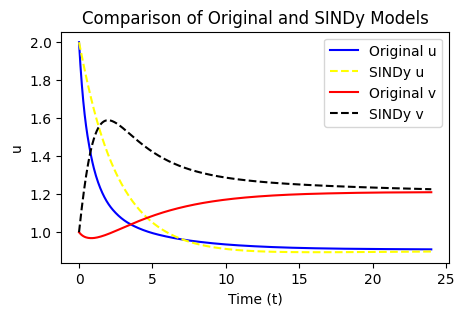

0.030303030303030304
(u)' = 0.402 cos(1 u) + -0.266 sin(1 v)
(v)' = -1.293 sin(1 u) + -0.867 cos(1 u) + 1.427 sin(1 v) + 0.612 cos(1 v)
0.04040404040404041
(u)' = 0.174 sin(1 u) + 0.438 cos(1 u) + -0.437 sin(1 v)
(v)' = -0.732 cos(1 u) + 0.476 sin(1 v)
0.05050505050505051
(u)' = 0.174 sin(1 u) + 0.438 cos(1 u) + -0.437 sin(1 v)
(v)' = -0.732 cos(1 u) + 0.476 sin(1 v)
0.06060606060606061
(u)' = 0.174 sin(1 u) + 0.438 cos(1 u) + -0.437 sin(1 v)
(v)' = -0.732 cos(1 u) + 0.476 sin(1 v)
0.07070707070707072
(u)' = -0.265 sin(1 u) + 0.341 cos(1 u)
(v)' = -0.732 cos(1 u) + 0.476 sin(1 v)
0.08080808080808081
(u)' = -0.265 sin(1 u) + 0.341 cos(1 u)
(v)' = -0.732 cos(1 u) + 0.476 sin(1 v)
0.09090909090909091
(u)' = -0.003 cos(1 u)
(v)' = -0.732 cos(1 u) + 0.476 sin(1 v)
0.10101010101010102
(u)' = -0.003 cos(1 u)
(v)' = -0.732 cos(1 u) + 0.476 sin(1 v)
0.11111111111111112
(u)' = -0.003 cos(1 u)
(v)' = -0.581 sin(1 u) + -0.850 cos(1 u) + 1.048 sin(1 v)
0.12121212121212122
(u)' = -0.003 cos(1 u)
(v)

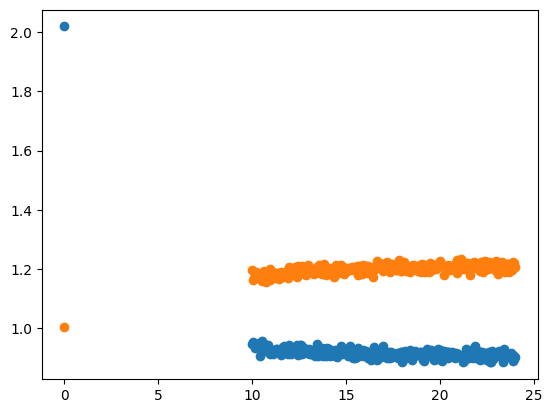

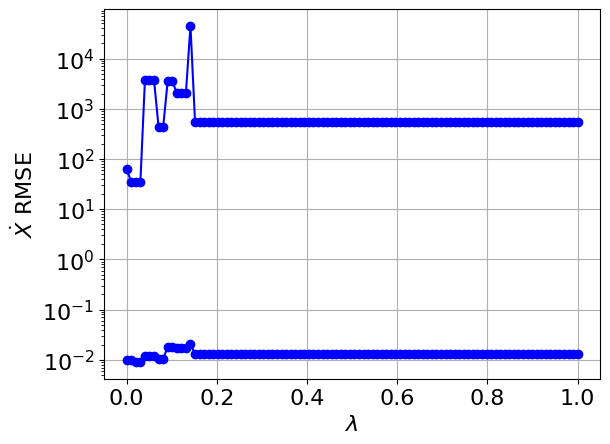

In [14]:
threshold_scan = np.linspace(0, 1, 100)
time_window = [10, 30]
mask = (t_train == 0) | ((t_train >= time_window[0]) & (t_train <= time_window[1]))
np.random.seed(0)
coefs= []

t_filtered = t_train[mask]
x_filtered = x_train[mask]

x_train_added_noise = x_filtered + np.random.normal(0, rmse / 100.0,  x_filtered.shape)
feature_names = ["u", "v"]

poly_order = 2
poly_library = PolynomialLibrary(degree=poly_order)
fourier_library = FourierLibrary()
combined_library = GeneralizedLibrary([poly_library, fourier_library])

for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.SR3(threshold=threshold, thresholder="l1")
    modelX = ps.SINDy(feature_names=feature_names,
                     optimizer=sparse_regression_optimizer, 
                     feature_library=fourier_library,)
    modelX.fit(x_train_added_noise, t=t_filtered, quiet=True)
    coefs.append(modelX.coefficients())
    print(threshold)
    modelX.print()
    if i == 2:
        plot_models(t_end, initial_conditions, params, competitionModel, modelX)

plt.scatter(t_filtered, x_train_added_noise[:,0])
plt.scatter(t_filtered, x_train_added_noise[:,1])
plot_pareto(coefs, sparse_regression_optimizer, modelX,
            threshold_scan, x_test, t_test)

0.0
(u)' = 632042.640 1 + 8640.362 u + 2644893.070 v + -3346.215 u^2 + 46.751 u v + -1105875.110 v^2 + -6851.507 sin(1 u) + -2024.758 cos(1 u) + -2058298.245 sin(1 v) + -810057.343 cos(1 v)
(v)' = 495500.423 1 + -27708.292 u + 2067417.523 v + 11858.422 u^2 + -17.342 u v + -867630.650 v^2 + 22554.141 sin(1 u) + 9746.291 cos(1 u) + -1612045.706 sin(1 v) + -642730.866 cos(1 v)
0.034482758620689655
(u)' = 632042.640 1 + 8640.362 u + 2644893.070 v + -3346.215 u^2 + 46.751 u v + -1105875.110 v^2 + -6851.507 sin(1 u) + -2024.758 cos(1 u) + -2058298.245 sin(1 v) + -810057.343 cos(1 v)
(v)' = 495500.423 1 + -27708.292 u + 2067417.523 v + 11858.422 u^2 + -17.342 u v + -867630.650 v^2 + 22554.141 sin(1 u) + 9746.291 cos(1 u) + -1612045.706 sin(1 v) + -642730.866 cos(1 v)
0.06896551724137931
(u)' = 632042.640 1 + 8640.362 u + 2644893.070 v + -3346.215 u^2 + 46.751 u v + -1105875.110 v^2 + -6851.507 sin(1 u) + -2024.758 cos(1 u) + -2058298.245 sin(1 v) + -810057.343 cos(1 v)
(v)' = 495500.423 1 + -

c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quanti

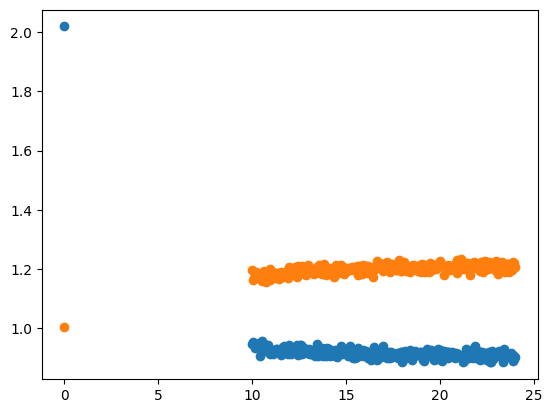

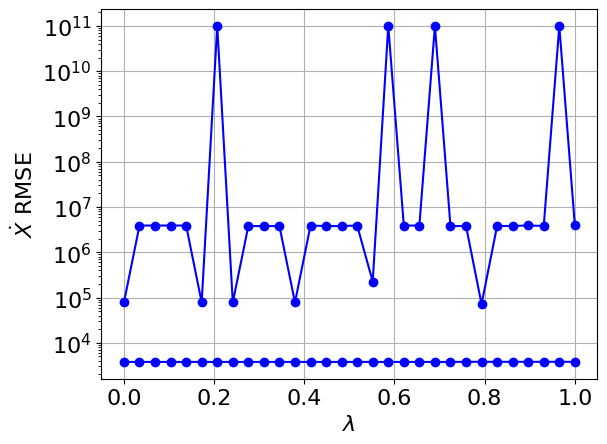

In [15]:
threshold_scan = np.linspace(0, 1, 30)
time_window = [10, 30]
mask = (t_train == 0) | ((t_train >= time_window[0]) & (t_train <= time_window[1]))
np.random.seed(0)
coefs= []

t_filtered = t_train[mask]
x_filtered = x_train[mask]

x_train_added_noise = x_filtered + np.random.normal(0, rmse / 100.0,  x_filtered.shape)
feature_names = ["u", "v"]

poly_order = 2
poly_library = PolynomialLibrary(degree=poly_order)
fourier_library = FourierLibrary()
combined_library = GeneralizedLibrary([poly_library, fourier_library])

for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.SR3(threshold=threshold, thresholder="l1")
    modelX = ps.SINDy(feature_names=feature_names,
                     optimizer=sparse_regression_optimizer, 
                     feature_library=combined_library,)
    modelX.fit(x_train_added_noise, t=t_filtered, quiet=True)
    coefs.append(modelX.coefficients())
    print(threshold)
    modelX.print()

plt.scatter(t_filtered, x_train_added_noise[:,0])
plt.scatter(t_filtered, x_train_added_noise[:,1])
plot_pareto(coefs, sparse_regression_optimizer, modelX,
            threshold_scan, x_test, t_test)

Let's use custom function only

x_train shape: (500, 2)
x_test shape: (500, 2)
Function output shape: (500,)
Function output shape: (500,)
Function output shape: (500,)
Function output shape: (500,)
Function output shape: (500,)
0.0
(u)' = 0.952 u + -0.288 v + -0.843 u^2 + -0.005 v^2 + 0.169 uv
(v)' = 0.018 u + 0.767 v + 0.131 u^2 + -0.309 v^2 + -0.545 uv
0.00101010101010101
(u)' = 0.952 u + -0.288 v + -0.843 u^2 + -0.005 v^2 + 0.169 uv
(v)' = 0.018 u + 0.767 v + 0.131 u^2 + -0.309 v^2 + -0.545 uv
0.00202020202020202
(u)' = 0.952 u + -0.288 v + -0.843 u^2 + -0.005 v^2 + 0.169 uv
(v)' = 0.018 u + 0.767 v + 0.131 u^2 + -0.309 v^2 + -0.545 uv
0.0030303030303030303
(u)' = 0.952 u + -0.288 v + -0.843 u^2 + -0.005 v^2 + 0.169 uv
(v)' = 0.018 u + 0.767 v + 0.131 u^2 + -0.309 v^2 + -0.545 uv
0.00404040404040404
(u)' = 0.952 u + -0.288 v + -0.843 u^2 + -0.005 v^2 + 0.169 uv
(v)' = 0.764 v + 0.126 u^2 + -0.319 v^2 + -0.509 uv
0.00505050505050505
(u)' = 0.952 u + -0.288 v + -0.843 u^2 + -0.005 v^2 + 0.169 uv
(v)' = 0.764 v + 0.

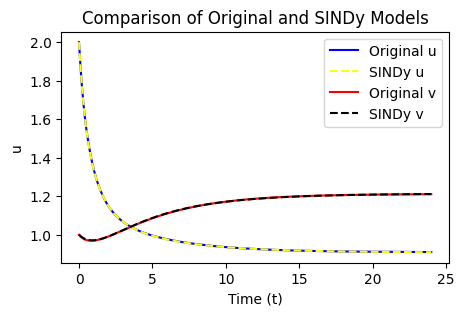

0.011111111111111112
(u)' = 1.019 u + -0.252 v + -0.809 u^2 + 0.032 v^2
(v)' = 0.469 v + -0.284 v^2 + -0.137 uv
0.012121212121212121
(u)' = 1.019 u + -0.252 v + -0.809 u^2 + 0.032 v^2
(v)' = 0.469 v + -0.284 v^2 + -0.137 uv
0.013131313131313131
(u)' = 0.852 u + -0.751 u^2 + -0.106 v^2
(v)' = 0.469 v + -0.284 v^2 + -0.137 uv
0.014141414141414142
(u)' = 0.852 u + -0.751 u^2 + -0.106 v^2
(v)' = 0.764 v + 0.126 u^2 + -0.319 v^2 + -0.509 uv
0.015151515151515152
(u)' = 0.852 u + -0.751 u^2 + -0.106 v^2
(v)' = 0.764 v + 0.126 u^2 + -0.319 v^2 + -0.509 uv
0.01616161616161616
(u)' = 0.852 u + -0.751 u^2 + -0.106 v^2
(v)' = 0.764 v + 0.126 u^2 + -0.319 v^2 + -0.509 uv
0.01717171717171717
(u)' = 0.852 u + -0.751 u^2 + -0.106 v^2
(v)' = 0.764 v + 0.126 u^2 + -0.319 v^2 + -0.509 uv
0.01818181818181818
(u)' = 0.852 u + -0.751 u^2 + -0.106 v^2
(v)' = 0.358 v + -0.046 u^2 + -0.270 v^2
0.01919191919191919
(u)' = 0.852 u + -0.751 u^2 + -0.106 v^2
(v)' = 0.358 v + -0.046 u^2 + -0.270 v^2
0.02020202020202

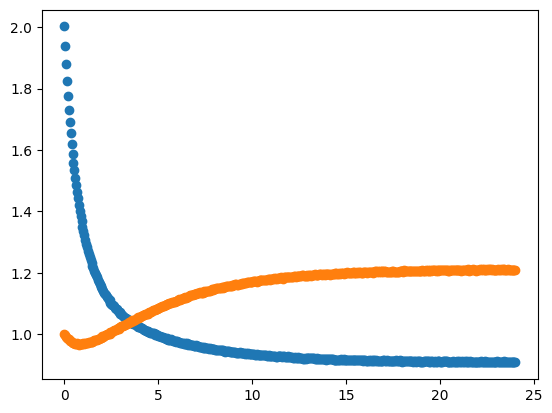

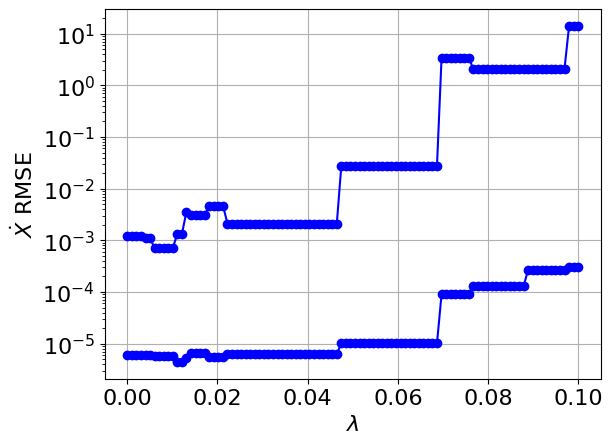

In [16]:
threshold_scan = np.linspace(0, 0.1, 100)
coefs = []
time_window = [0, 30]
mask = (t_train == 0) | ((t_train >= time_window[0]) & (t_train <= time_window[1]))
np.random.seed(0)

t_filtered = t_train[mask]
x_filtered = x_train[mask]

x_train_added_noise = x_filtered + np.random.normal(0, rmse / 1000.0,  x_filtered.shape)
feature_names = ["u", "v"]

# poly_order = 2
# poly_library = PolynomialLibrary(degree=poly_order)
# fourier_library = FourierLibrary()
# combined_library = GeneralizedLibrary([poly_library, fourier_library])
custom_functions = [lambda u,v:u, 
                    lambda u,v:v, 
                    lambda u,v:u**2, 
                    lambda u,v: v**2, 
                    lambda u,v:u*v]
function_names = [
                lambda u, v: f"{u}",
                lambda u, v: f"{v}",
                lambda u, v: f"{u}^2",
                lambda u, v: f"{v}^2",
                lambda u, v: f"{u}{v}"
            ]

custom_library = CustomLibrary(library_functions=custom_functions, function_names=function_names, include_bias=False).fit(x_train[:,0], x_train[:,1])

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
for f in custom_functions:
    print("Function output shape:", f(x_train[:,0], x_train[:,1]).shape)


for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.SR3(threshold=threshold, thresholder="l1")
    modelX = ps.SINDy(feature_names=feature_names,
                     optimizer=sparse_regression_optimizer, 
                     feature_library=custom_library,)
    modelX.fit(x_train_added_noise, t=t_filtered, quiet=True)
    coefs.append(modelX.coefficients())
    print(threshold)
    modelX.print()
    if i == 10:
        plot_models(t_end, initial_conditions, params, competitionModel, modelX)

print(custom_library.get_feature_names())
print(modelX.n_features_in_)
print(modelX.n_output_features_)
print(custom_library.get_feature_names())

print(x_test.shape)
print(coefs[0])
print(coefs[0].shape)
plt.scatter(t_filtered, x_train_added_noise[:,0])
plt.scatter(t_filtered, x_train_added_noise[:,1])
plot_pareto(coefs, sparse_regression_optimizer, modelX,
            threshold_scan, x_test, t_test)

x_train shape: (500, 2)
x_test shape: (500, 2)
Function output shape: (500,)
Function output shape: (500,)
Function output shape: (500,)
Function output shape: (500,)
Function output shape: (500,)
0.0
(u)' = -3.184 u + 2.520 v + 0.373 u^2 + -1.787 v^2 + 1.957 uv
(v)' = -11.238 u + 8.718 v + 1.477 u^2 + -6.476 v^2 + 7.207 uv
0.0030303030303030303
(u)' = -3.184 u + 2.520 v + 0.373 u^2 + -1.787 v^2 + 1.957 uv
(v)' = -11.238 u + 8.718 v + 1.477 u^2 + -6.476 v^2 + 7.207 uv
0.006060606060606061
(u)' = -3.184 u + 2.520 v + 0.373 u^2 + -1.787 v^2 + 1.957 uv
(v)' = -11.238 u + 8.718 v + 1.477 u^2 + -6.476 v^2 + 7.207 uv
0.00909090909090909
(u)' = -3.184 u + 2.520 v + 0.373 u^2 + -1.787 v^2 + 1.957 uv
(v)' = -11.238 u + 8.718 v + 1.477 u^2 + -6.476 v^2 + 7.207 uv
0.012121212121212121
(u)' = -3.184 u + 2.520 v + 0.373 u^2 + -1.787 v^2 + 1.957 uv
(v)' = -11.238 u + 8.718 v + 1.477 u^2 + -6.476 v^2 + 7.207 uv
0.015151515151515152
(u)' = -3.184 u + 2.520 v + 0.373 u^2 + -1.787 v^2 + 1.957 uv
(v)' = 

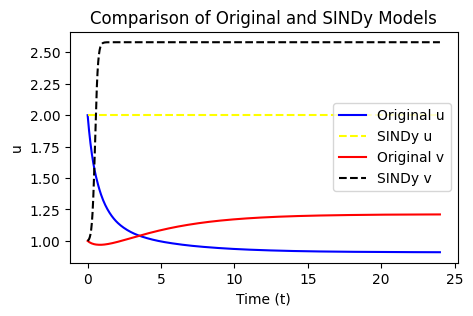

0.12424242424242424
(u)' = 0.000
(v)' = -11.238 u + 8.718 v + 1.477 u^2 + -6.476 v^2 + 7.207 uv
0.12727272727272726
(u)' = 0.000
(v)' = -11.238 u + 8.718 v + 1.477 u^2 + -6.476 v^2 + 7.207 uv
0.1303030303030303
(u)' = 0.000
(v)' = -11.238 u + 8.718 v + 1.477 u^2 + -6.476 v^2 + 7.207 uv
0.13333333333333333
(u)' = 0.000
(v)' = -11.238 u + 8.718 v + 1.477 u^2 + -6.476 v^2 + 7.207 uv
0.13636363636363635
(u)' = 0.000
(v)' = -11.238 u + 8.718 v + 1.477 u^2 + -6.476 v^2 + 7.207 uv
0.1393939393939394
(u)' = 0.000
(v)' = -11.238 u + 8.718 v + 1.477 u^2 + -6.476 v^2 + 7.207 uv
0.14242424242424243
(u)' = 0.000
(v)' = -11.238 u + 8.718 v + 1.477 u^2 + -6.476 v^2 + 7.207 uv
0.14545454545454545
(u)' = 0.000
(v)' = -11.238 u + 8.718 v + 1.477 u^2 + -6.476 v^2 + 7.207 uv
0.1484848484848485
(u)' = 0.000
(v)' = -11.238 u + 8.718 v + 1.477 u^2 + -6.476 v^2 + 7.207 uv
0.15151515151515152
(u)' = 0.000
(v)' = -11.238 u + 8.718 v + 1.477 u^2 + -6.476 v^2 + 7.207 uv
0.15454545454545454
(u)' = 0.000
(v)' = -11

c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quanti

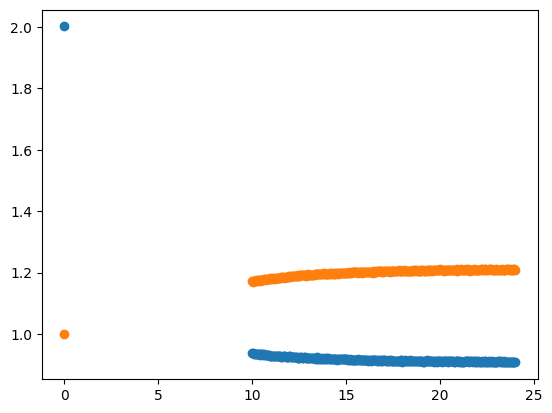

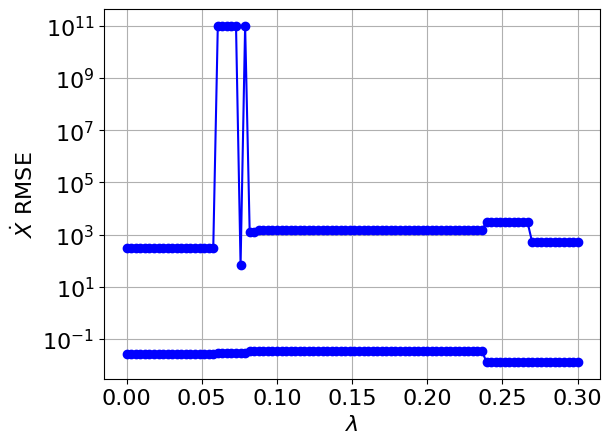

In [17]:
threshold_scan = np.linspace(0, 0.3, 100)
coefs = []
time_window = [10, 30]
mask = (t_train == 0) | ((t_train >= time_window[0]) & (t_train <= time_window[1]))
np.random.seed(0)

t_filtered = t_train[mask]
x_filtered = x_train[mask]

x_train_added_noise = x_filtered + np.random.normal(0, rmse / 1000.0,  x_filtered.shape)
feature_names = ["u", "v"]

# poly_order = 2
# poly_library = PolynomialLibrary(degree=poly_order)
# fourier_library = FourierLibrary()
# combined_library = GeneralizedLibrary([poly_library, fourier_library])
custom_functions = [lambda u,v:u, 
                    lambda u,v:v, 
                    lambda u,v:u**2, 
                    lambda u,v: v**2, 
                    lambda u,v:u*v]
function_names = [
                lambda u, v: f"{u}",
                lambda u, v: f"{v}",
                lambda u, v: f"{u}^2",
                lambda u, v: f"{v}^2",
                lambda u, v: f"{u}{v}"
            ]

custom_library = CustomLibrary(library_functions=custom_functions, function_names=function_names, include_bias=False).fit(x_train[:,0], x_train[:,1])

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
for f in custom_functions:
    print("Function output shape:", f(x_train[:,0], x_train[:,1]).shape)


for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.SR3(threshold=threshold, thresholder="l1")
    modelX = ps.SINDy(feature_names=feature_names,
                     optimizer=sparse_regression_optimizer, 
                     feature_library=custom_library,)
    modelX.fit(x_train_added_noise, t=t_filtered, quiet=True)
    coefs.append(modelX.coefficients())
    print(threshold)
    modelX.print()
    if i == 40:
        plot_models(t_end, initial_conditions, params, competitionModel, modelX)

print(custom_library.get_feature_names())
print(modelX.n_features_in_)
print(modelX.n_output_features_)
print(custom_library.get_feature_names())

print(x_test.shape)
print(coefs[0])
print(coefs[0].shape)
plt.scatter(t_filtered, x_train_added_noise[:,0])
plt.scatter(t_filtered, x_train_added_noise[:,1])
plot_pareto(coefs, sparse_regression_optimizer, modelX,
            threshold_scan, x_test, t_test)

x_train shape: (500, 2)
x_test shape: (500, 2)
Function output shape: (500,)
Function output shape: (500,)
Function output shape: (500,)
Function output shape: (500,)
Function output shape: (500,)
0.0
(u)' = 0.767 u + -0.730 v + -1.173 u^2 + -0.165 v^2 + 1.262 uv
(v)' = -1.590 u + 2.031 v + 0.341 u^2 + -1.367 v^2 + 0.634 uv
0.00101010101010101
(u)' = 0.767 u + -0.730 v + -1.173 u^2 + -0.165 v^2 + 1.262 uv
(v)' = -1.590 u + 2.031 v + 0.341 u^2 + -1.367 v^2 + 0.634 uv
0.00202020202020202
(u)' = 0.767 u + -0.730 v + -1.173 u^2 + -0.165 v^2 + 1.262 uv
(v)' = -1.590 u + 2.031 v + 0.341 u^2 + -1.367 v^2 + 0.634 uv
0.0030303030303030303
(u)' = 0.767 u + -0.730 v + -1.173 u^2 + -0.165 v^2 + 1.262 uv
(v)' = -1.590 u + 2.031 v + 0.341 u^2 + -1.367 v^2 + 0.634 uv
0.00404040404040404
(u)' = 0.767 u + -0.730 v + -1.173 u^2 + -0.165 v^2 + 1.262 uv
(v)' = -1.590 u + 2.031 v + 0.341 u^2 + -1.367 v^2 + 0.634 uv
0.00505050505050505
(u)' = 0.767 u + -0.730 v + -1.173 u^2 + -0.165 v^2 + 1.262 uv
(v)' = -1

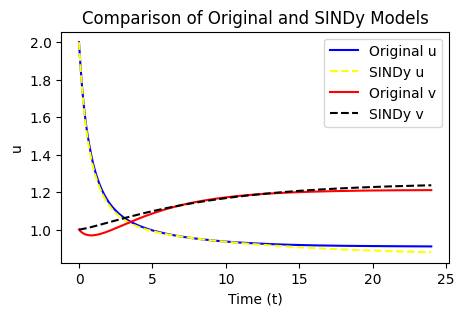

0.05858585858585859
(u)' = 0.959 u + -0.815 u^2 + -0.141 v^2
(v)' = -0.018 u + 0.178 v + -0.132 v^2
0.0595959595959596
(u)' = 0.959 u + -0.815 u^2 + -0.141 v^2
(v)' = 0.111 v + -0.087 v^2
0.06060606060606061
(u)' = 0.959 u + -0.815 u^2 + -0.141 v^2
(v)' = 0.111 v + -0.087 v^2
0.06161616161616162
(u)' = 0.959 u + -0.815 u^2 + -0.141 v^2
(v)' = 0.111 v + -0.087 v^2
0.06262626262626263
(u)' = 0.959 u + -0.815 u^2 + -0.141 v^2
(v)' = 0.111 v + -0.087 v^2
0.06363636363636363
(u)' = 0.959 u + -0.815 u^2 + -0.141 v^2
(v)' = 0.013 v
0.06464646464646465
(u)' = 0.959 u + -0.815 u^2 + -0.141 v^2
(v)' = 0.000
0.06565656565656566
(u)' = 0.959 u + -0.815 u^2 + -0.141 v^2
(v)' = 0.000
0.06666666666666667
(u)' = 0.959 u + -0.815 u^2 + -0.141 v^2
(v)' = 0.000
0.06767676767676768
(u)' = 0.959 u + -0.815 u^2 + -0.141 v^2
(v)' = 0.000
0.06868686868686869
(u)' = 0.959 u + -0.815 u^2 + -0.141 v^2
(v)' = 0.000
0.0696969696969697
(u)' = 0.959 u + -0.815 u^2 + -0.141 v^2
(v)' = 0.000
0.0707070707070707
(u)' = 

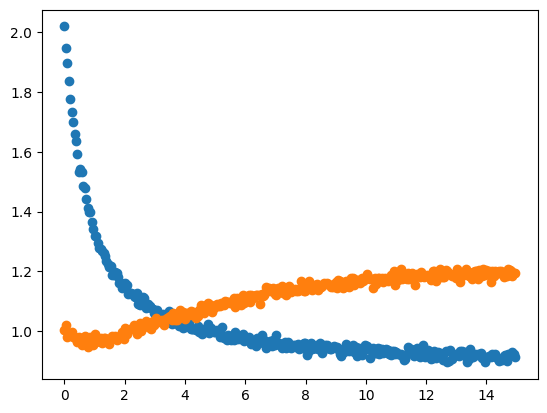

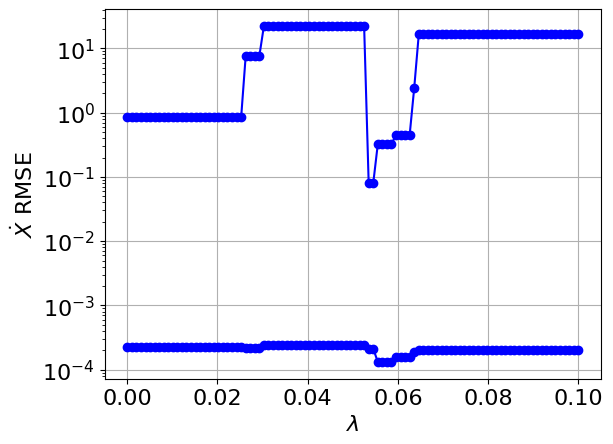

In [18]:
threshold_scan = np.linspace(0, 0.1, 100)
coefs = []
time_window = [0, 15]
mask = (t_train == 0) | ((t_train >= time_window[0]) & (t_train <= time_window[1]))
np.random.seed(0)

t_filtered = t_train[mask]
x_filtered = x_train[mask]

x_train_added_noise = x_filtered + np.random.normal(0, rmse / 100.0,  x_filtered.shape)
feature_names = ["u", "v"]

# poly_order = 2
# poly_library = PolynomialLibrary(degree=poly_order)
# fourier_library = FourierLibrary()
# combined_library = GeneralizedLibrary([poly_library, fourier_library])
custom_functions = [lambda u,v:u, 
                    lambda u,v:v, 
                    lambda u,v:u**2, 
                    lambda u,v: v**2, 
                    lambda u,v:u*v]
function_names = [
                lambda u, v: f"{u}",
                lambda u, v: f"{v}",
                lambda u, v: f"{u}^2",
                lambda u, v: f"{v}^2",
                lambda u, v: f"{u}{v}"
            ]

custom_library = CustomLibrary(library_functions=custom_functions, function_names=function_names, include_bias=False).fit(x_train[:,0], x_train[:,1])

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
for f in custom_functions:
    print("Function output shape:", f(x_train[:,0], x_train[:,1]).shape)


for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.SR3(threshold=threshold, thresholder="l1")
    modelX = ps.SINDy(feature_names=feature_names,
                     optimizer=sparse_regression_optimizer, 
                     feature_library=custom_library,)
    modelX.fit(x_train_added_noise, t=t_filtered, quiet=True)
    coefs.append(modelX.coefficients())
    print(threshold)
    modelX.print()
    if i == 57:
        plot_models(t_end, initial_conditions, params, competitionModel, modelX)

print(custom_library.get_feature_names())
print(modelX.n_features_in_)
print(modelX.n_output_features_)
print(custom_library.get_feature_names())

print(x_test.shape)
print(coefs[0])
print(coefs[0].shape)
plt.scatter(t_filtered, x_train_added_noise[:,0])
plt.scatter(t_filtered, x_train_added_noise[:,1])
plot_pareto(coefs, sparse_regression_optimizer, modelX,
            threshold_scan, x_test, t_test)

In [ ]:
def create_datasets(model, tend, initial_conditions, params, training_time_limit, noise_level, show_figure):
    tend = tend
    t_span = (0, tend)
    t_eval = np.linspace(t_span[0], t_span[1], 500)
    initial_conditions = initial_conditions
    # training datasets
    sol = solve_ivp(model, t_span, initial_conditions, args=(params,), t_eval=t_eval)
    t_train = sol.t
    x_train = sol.y.T

    mask = (t_train == 0) | ((t_train >= training_time_limit[0]) & (t_train <= training_time_limit[1]))
    t_filtered = t_train[mask]
    x_filtered = x_train[mask]

    noise = np.random.normal(0, noise_level, x_filtered.shape)
    x_filtered_noisy = x_filtered + noise
    u_train = x_filtered_noisy[:, 0]
    v_train = x_filtered_noisy[:, 1]

    # Test datasets
    sol_test = solve_ivp(model, t_span, initial_conditions, args=(params,), t_eval=t_eval)
    t_test = sol_test.t
    x_test = sol_test.y.T
    u_test = sol_test.y[0]
    v_test = sol_test.y[1]

    if show_figure:
        plt.figure(figsize=(5, 3))
        plt.scatter(t_filtered, u_train, label='u(t)')
        plt.scatter(t_filtered, v_train, label='v(t)')
        plt.xlabel('Time (t)')
        plt.ylabel('u')
        plt.title('Competition Model Data')
        plt.legend()
        plt.show()

    return x_train, t_train, x_test, t_test

In [ ]:
x_train, t_train, x_test, t_test = create_datasets(competitionModel, t_end, initial_conditions, params, [15, 30], 0.0005, show_figure=True)